<a href="https://colab.research.google.com/github/BlueBug12/stock/blob/master/bin/cloud/CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 54.0MB/s 
     |████████████████████████████████| 3.0MB 55.9MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [1]:
!nvidia-smi

Mon Nov 16 05:26:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Dense, Activation,MaxPooling1D, GlobalAveragePooling1D, Dropout, Lambda, RepeatVector, Input, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math


In [3]:
print(tensorflow.__version__)

2.2.0


In [4]:
def buildYTrain(train, pastDay, futureDay,profit):
    Y_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        ave = np.mean(train['high'][i+pastDay+1:i+pastDay+futureDay])
        if train['close'][i+pastDay] > train['close'][i+pastDay-1]:
            Y_train.append(1)
        else:
            Y_train.append(0)

        #if (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] > profit:
        #    Y_train.append(0)
        #elif (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] < -profit:
        #    Y_train.append(1)
        #else:
        #    Y_train.append(1)     
    return np.array(Y_train)

def buildXTrain(train, pastDay, futureDay,profit):
    X_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
    return np.array(X_train)

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [7]:
from google.colab import files
uploaded = files.upload()

Saving 2330.pickle to 2330.pickle


In [8]:
!mkdir data
!mv 2330.pickle data/

In [9]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
    print(df.tail())
    print(df.shape)
    df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)
    
    '''
    df = df[['open','high','low','close','volume']]
    df['diff1'] = df['close']-df['open']
    df['diff2']= df['close']-df['low']
    df['diff3']= df['high']-df['close']
    df['diff4']= df['high']-df['low']
    df['diff5']= df['open']-df['low']
    df['diff5']= df['high']-df['open']

    '''
    

    

      adj_close  close   high    low  ...     ema_D        RS        RSI       OBV
4102      458.0  458.5  460.0  454.0  ...  1.354608  2.197155  68.722188  0.750000
4103      451.0  451.0  454.5  448.5  ...  2.173993  1.186501  54.264824  0.416667
4104      456.5  457.0  457.0  448.5  ...  1.884128  1.611101  61.701972  1.000000
4105      457.5  458.0  463.5  457.5  ...  1.632911  1.692754  62.863303  0.083333
4106      461.5  462.0  462.0  456.5  ...  1.415189  2.069618  67.422656  1.000000

[5 rows x 36 columns]
(4107, 36)


In [10]:
past = 60
future = 5
profit = 0.01
val_ratio = 0.2
num_classes=2
data_y = buildYTrain(df.copy().iloc[:-100],past,future,profit)
df.drop(['open','high','low','close'],axis=1,inplace=True)
data = normalize_data(df.copy().iloc[:-100])

data_x = buildXTrain(data,past,future,profit)


In [11]:
print(data_y.shape)
print(data_x.shape)
more=0
less=0
equal=0
for i in range(data_y.shape[0]):
    if data_y[i]==0:
        more+=1
    elif data_y[i]==1:
        less+=1
    else:
        equal+=1
print(more,less,equal)
    

(3942,)
(3942, 60, 27)
2047 1895 0


In [12]:
data_X, data_Y = shuffle(data_x, data_y)
x_train, y_train, x_val, y_val = splitData(data_X, data_Y, val_ratio)
Y_train = to_categorical(y_train, num_classes=num_classes)
Y_val = to_categorical(y_val, num_classes=num_classes)

In [13]:
print(Y_val.shape)
x_train.shape[1:]

(788, 2)


(60, 27)

In [14]:
backend.clear_session()

model = Sequential()
model.add(Conv1D(64, 1, activation='selu', input_shape=(x_train.shape[1:])))
model.add(MaxPooling1D(2))
#model.add(Conv1D(300, 5, activation='selu'))
model.add(Conv1D(128, 3, activation='selu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='selu'))

#model.add(Conv1D(160, 3, activation='selu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(200, activation='selu'))
#model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(2, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 64)            1792      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 128)           49280     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               3

Epoch 1/1000
25/25 [==============================] - 0s 18ms/step - loss: 1.9909 - accuracy: 0.4914 - val_loss: 0.7674 - val_accuracy: 0.5165
Epoch 2/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.7148 - accuracy: 0.5181 - val_loss: 0.7068 - val_accuracy: 0.4975
Epoch 3/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5409 - val_loss: 0.7033 - val_accuracy: 0.4962
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5501 - val_loss: 0.7041 - val_accuracy: 0.4873
Epoch 5/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5507 - val_loss: 0.7199 - val_accuracy: 0.5127
Epoch 6/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5640 - val_loss: 0.7813 - val_accuracy: 0.4759
Epoch 7/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5653 - val_loss: 0.7271 - val_accuracy: 0.4797
Epoch

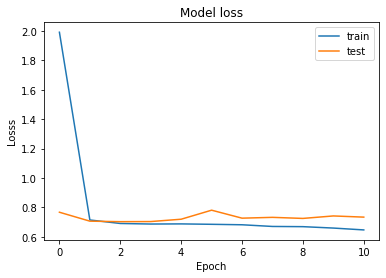

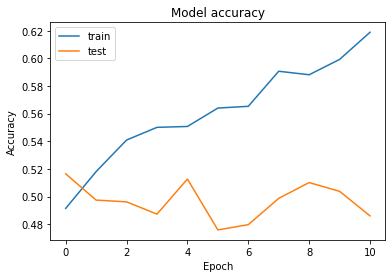

In [15]:
callback = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="auto")
history=model.fit(x_train, Y_train, epochs=1000, batch_size=128, validation_data=(x_val, Y_val), callbacks=[callback])
training_result(history)

In [11]:
ans=model.predict(x_train)

In [12]:
ans[-20:]

array([[1.0000000e+00, 1.4453367e-17],
       [1.0000000e+00, 2.4451005e-20],
       [1.0000000e+00, 2.1627661e-17],
       [1.0000000e+00, 1.2303630e-12],
       [1.0000000e+00, 8.1852946e-18],
       [1.0000000e+00, 1.7601897e-16],
       [1.0000000e+00, 1.8225358e-12],
       [1.0000000e+00, 1.1647127e-13],
       [1.0000000e+00, 2.7832309e-16],
       [1.0000000e+00, 3.1631258e-17],
       [1.0000000e+00, 1.2488341e-14],
       [1.0000000e+00, 3.5833924e-15],
       [1.0000000e+00, 1.7141177e-15],
       [1.0000000e+00, 1.2898460e-14],
       [1.0000000e+00, 4.6907774e-20],
       [1.0000000e+00, 1.4356577e-20],
       [1.0000000e+00, 2.7120155e-15],
       [1.0000000e+00, 6.2348081e-13],
       [1.0000000e+00, 4.3120593e-20],
       [1.0000000e+00, 2.7482475e-15]], dtype=float32)